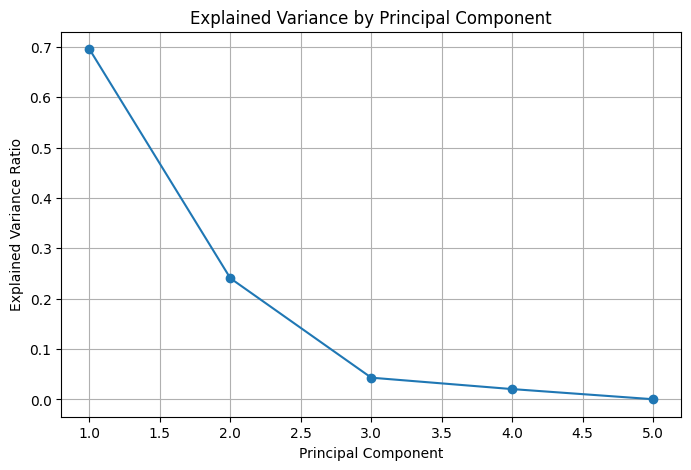

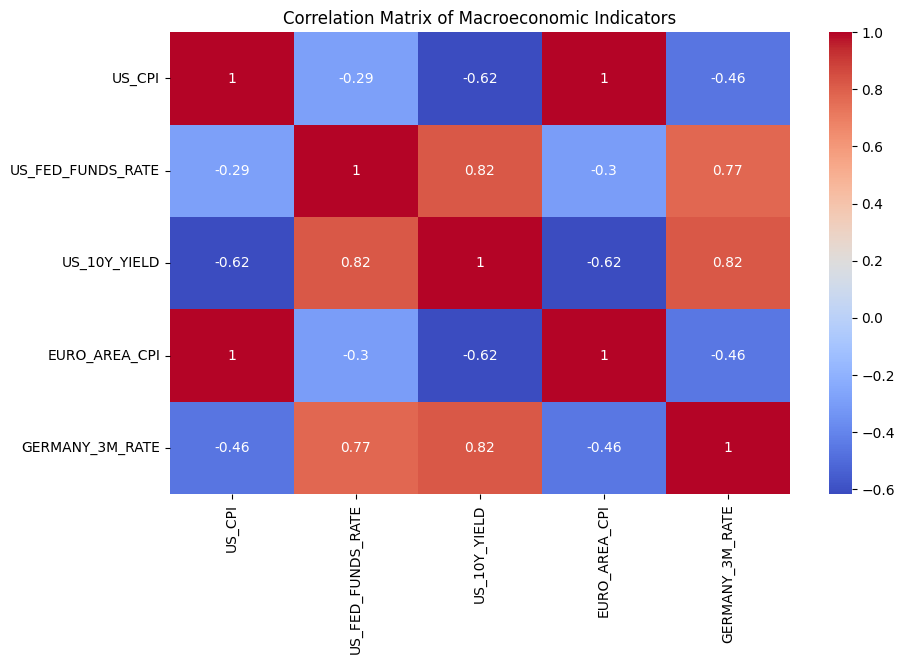

<Axes: title={'center': 'Principal Component 1 (Macro Trend)'}, xlabel='Date'>

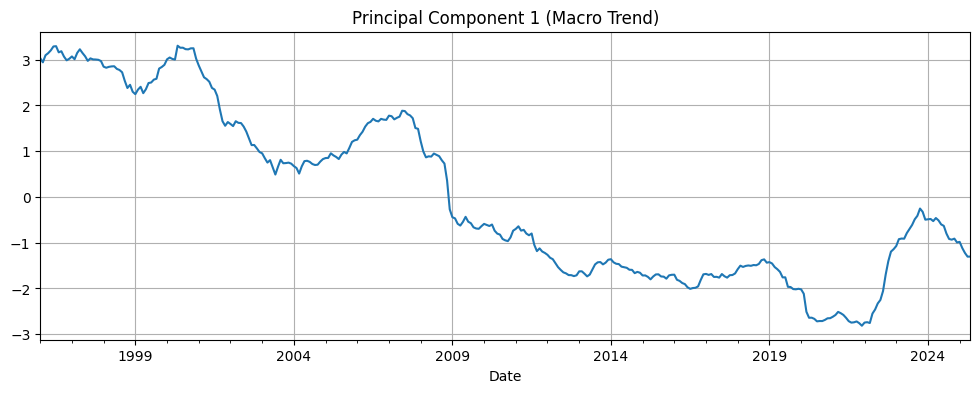

In [1]:
# notebooks/pca_macro_analysis.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load macroeconomic data
macro_df = pd.read_csv("../data/macro_data.csv", parse_dates=["Date"], index_col="Date")
macro_df.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(macro_df)

# Run PCA
pca = PCA(n_components=min(len(macro_df.columns), 5))
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, index=macro_df.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# Correlation heatmap of original macro indicators
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(X_scaled, columns=macro_df.columns).corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Matrix of Macroeconomic Indicators")
plt.show()

# Visualize PC1 over time
pca_df['PC1'].plot(figsize=(12, 4), title="Principal Component 1 (Macro Trend)", grid=True)
